In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.metrics import Recall
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
import seaborn as sns

#### 1- Scaling 

In [2]:
df = pd.read_csv('ext_seq_ai4i.csv')

In [3]:
# We MinMax Normalize features
scaler = MinMaxScaler()
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temperature difference [k]', 'Power [W]', 'Strain [minNm]']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Prepare sequences  for time series representation by 'Product ID'
grouped = df.groupby('Product ID')
max_sequence_length = 10  # This is be based on the maximum sequence length observed

X = []
y = []

In [4]:
# Below we ensure matching dimensionality to proceed with training after sequencing
for _, group in grouped:
    sequence = group[feature_cols].values
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
    X.append(sequence)
    y.append(group[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].values[-1])

X_padded = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)
y = np.array(y)

print(f"Shape of X_padded: {X_padded.shape}")
print(f"Shape of y: {y.shape}")



Shape of X_padded: (10000, 10, 8)
Shape of y: (10000, 5)


#### 2- Model Training

In [5]:
models = {}

# Resample using SMOTE for each failure type separately, assuming binary classification
for i, failure_type in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF']):
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X_padded.reshape(X_padded.shape[0], -1), y[:, i])
    X_res = X_res.reshape(-1, max_sequence_length, len(feature_cols))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(max_sequence_length, len(feature_cols)), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    models[failure_type] = model
    
    loss, recall = model.evaluate(X_test, y_test)
    print(f"Recall for {failure_type}: {recall:.2f}")



Epoch 1/10

498/498 [==============================] - 8s 10ms/step - loss: 0.2018 - recall: 0.9758 - val_loss: 0.1550 - val_recall: 1.0000
Epoch 2/10
498/498 [==============================] - 4s 8ms/step - loss: 0.1523 - recall: 0.9897 - val_loss: 0.1990 - val_recall: 1.0000
Epoch 3/10
498/498 [==============================] - 4s 8ms/step - loss: 0.1469 - recall: 0.9922 - val_loss: 0.1393 - val_recall: 0.9812
Epoch 4/10
498/498 [==============================] - 4s 8ms/step - loss: 0.1431 - recall: 0.9931 - val_loss: 0.1253 - val_recall: 0.9985
Epoch 5/10
498/498 [==============================] - 4s 7ms/step - loss: 0.1440 - recall: 0.9916 - val_loss: 0.1243 - val_recall: 0.9944
Epoch 6/10
498/498 [==============================] - 4s 7ms/step - loss: 0.1361 - recall: 0.9940 - val_loss: 0.1410 - val_recall: 0.9893
Epoch 7/10
498/498 [==============================] - 4s 7ms/step - loss: 0.1290 - recall: 0.9944 - val_loss: 0.1195 - val_recall: 1.0000
Epoch 8/10
498/498 [==========

#### 3- Preformance Metrics

125/125 [==============================] - 0s 3ms/step


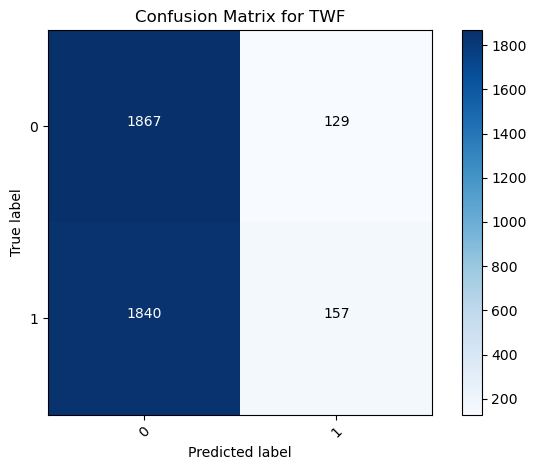

F1 Score for TWF: 0.14
125/125 [==============================] - 0s 3ms/step


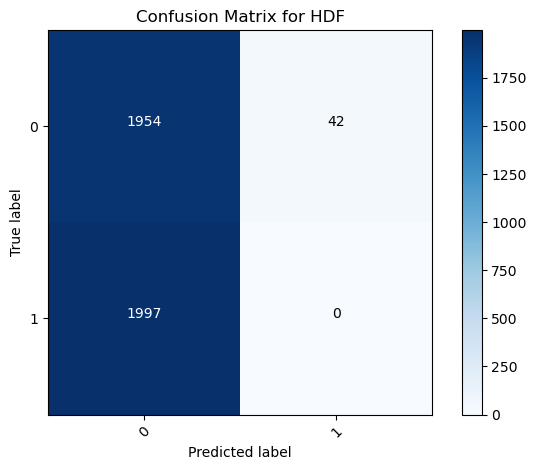

F1 Score for HDF: 0.00
125/125 [==============================] - 0s 3ms/step


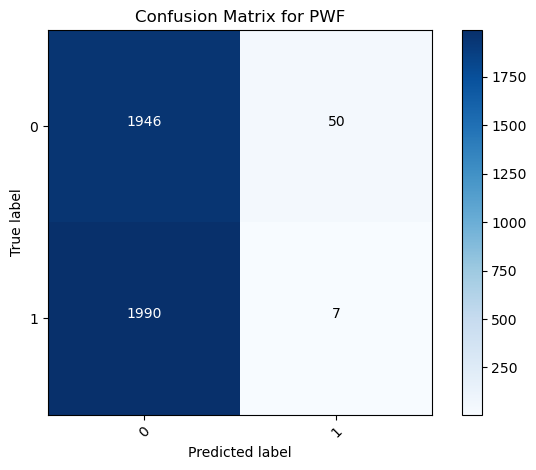

F1 Score for PWF: 0.01
125/125 [==============================] - 0s 3ms/step


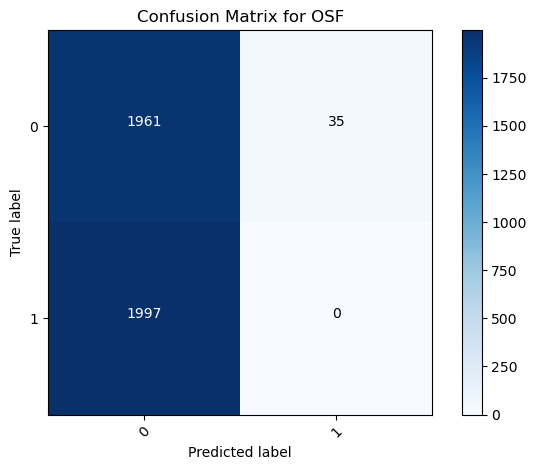

F1 Score for OSF: 0.00
125/125 [==============================] - 0s 3ms/step


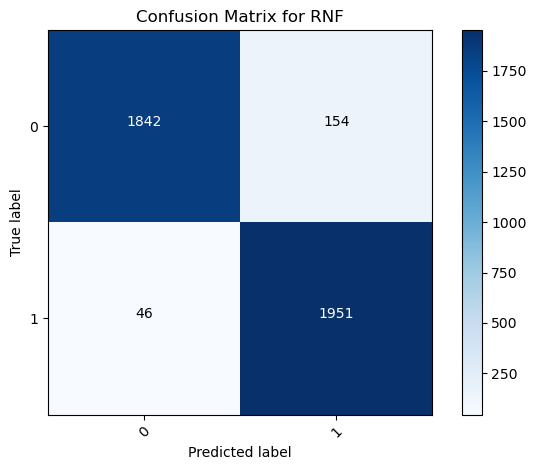

F1 Score for RNF: 0.95


In [18]:
# Lets visualize below how well are we scoring on different failure types
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):  
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

failure_types =['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for i, failure_type in enumerate(failure_types):
    model = models[failure_type]
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=[0, 1], title=f'Confusion Matrix for {failure_type}')
    plt.show()
    
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {failure_type}: {f1:.2f}")

#### 4- Testing

In [10]:
# Let us sample 20000 unseen data points to preprocess and test

new_df = df.sample(n=20000, replace=False, random_state=42) 

target_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
new_df = new_df.drop(columns=target_columns)


print(new_df.head())

         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
119737  5931     L53110    L             0.543478                 0.567901   
72272   2081     L49260    L             0.434783                 0.432099   
158154  8670     M23529    M             0.239130                 0.382716   
65426   4310     M19169    M             0.652174                 0.518519   
30074   5714     L52893    L             0.750000                 0.765432   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  \
119737                0.183353     0.656593         0.197628   
72272                 0.647264     0.159341         0.818182   
158154                0.176368     0.666209         0.600791   
65426                 0.193830     0.490385         0.106719   
30074                 0.249127     0.469780         0.616601   

        Temperature difference [k]  Power [W]  Strain [minNm]  
119737                    0.533333   0.736472        0.156392  
72272             

In [11]:
# Below we will test for each failure type on the unseen data points
new_features = new_df[feature_cols] 

# Normalize the features using the MinMax scaler
new_features = scaler.transform(new_features)

# Preprocess sequences and pad as done above
grouped = new_df.groupby('Product ID')
X_new = []

for _, group in grouped:
    sequence = group[feature_cols].values
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length] 
    X_new.append(sequence)

X_new_padded = pad_sequences(X_new, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)


failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
predictions = {}

# Test our LSTM on the new chosen test datapoints from the augmented dataset
for failure_type in failure_types:
    model = models[failure_type]  
    predictions[failure_type] = model.predict(X_new_padded)

for failure_type, prediction in predictions.items():
    print(f"Predictions for {failure_type}:")
    print(prediction)  

271/271 [==============================] - 1s 3ms/step
Predictions for TWF:
[[1.9900777e-05]
 [1.9841635e-05]
 [2.0974734e-05]
 ...
 [2.1291542e-05]
 [2.1101672e-05]
 [2.1002437e-05]]
Predictions for HDF:
[[5.7180036e-06]
 [5.9424201e-06]
 [6.5272397e-06]
 ...
 [9.5842171e-01]
 [9.3432230e-01]
 [9.8293740e-01]]
Predictions for PWF:
[[4.0334955e-05]
 [2.7146390e-05]
 [3.5269470e-05]
 ...
 [2.5747248e-03]
 [9.7418355e-04]
 [3.0890858e-04]]
Predictions for OSF:
[[6.8391300e-06]
 [6.7312508e-06]
 [7.4613827e-06]
 ...
 [7.1966178e-06]
 [7.1842951e-06]
 [7.2296011e-06]]
Predictions for RNF:
[[0.00036616]
 [0.00013374]
 [0.00047595]
 ...
 [0.00073253]
 [0.00071757]
 [0.00062731]]


271/271 [==============================] - 1s 2ms/step


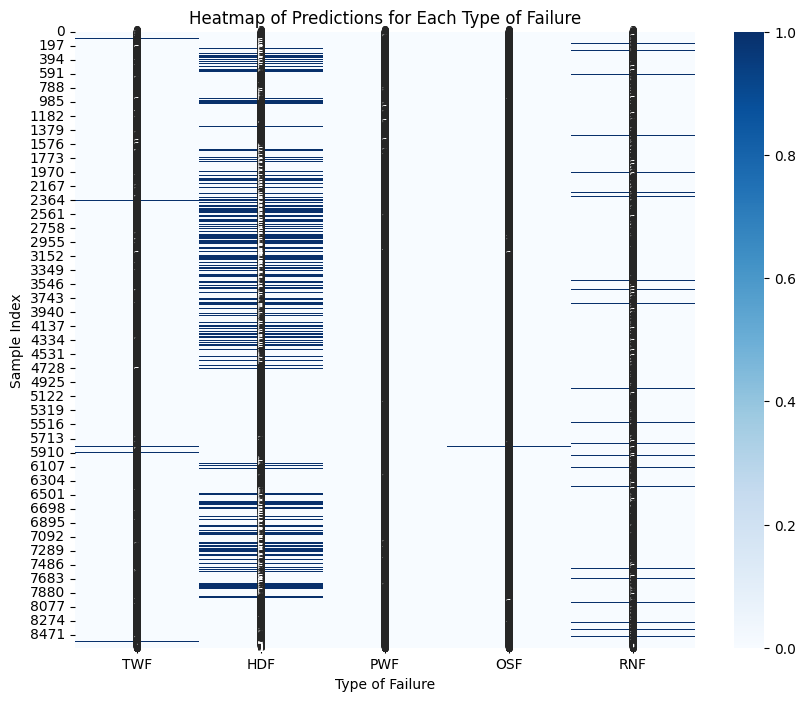

In [9]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
prediction_values = [models[ftype].predict(X_new_padded) for ftype in failure_types]

# Convert probabilities over 0.5 to 1 else 0
binary_predictions = [np.where(preds > 0.5, 1, 0) for preds in prediction_values]

# Combine into a matrix for heatmap visualization
combined_predictions = np.column_stack(binary_predictions)

# Create a heatmap for each failure type
plt.figure(figsize=(10, 8))
sns.heatmap(combined_predictions, annot=True, fmt='d', cmap='Blues', xticklabels=failure_types)
plt.title('Heatmap of Predictions for Each Type of Failure')
plt.xlabel('Type of Failure')
plt.ylabel('Sample Index')
plt.show()


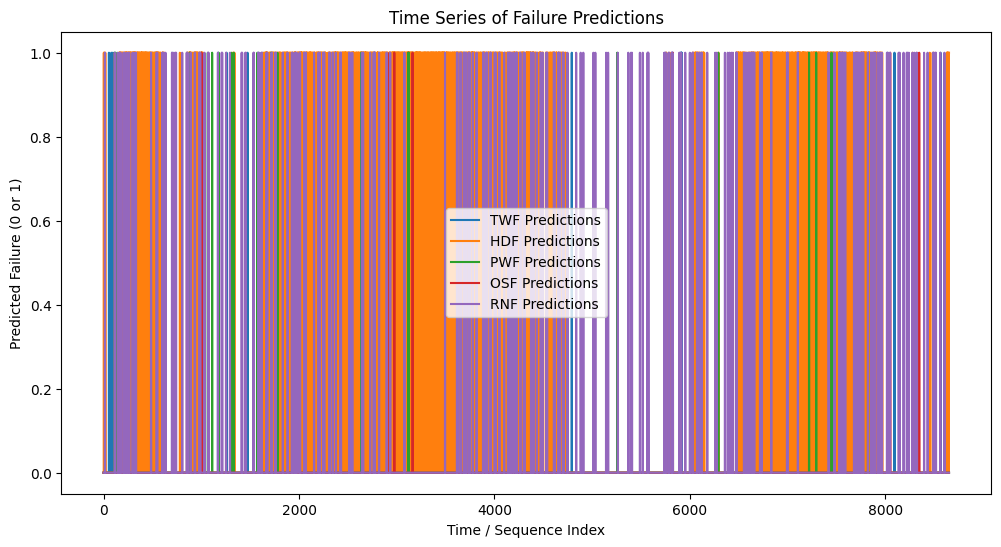

In [10]:
#Now lets visualize the failures in order of a time series sequence
time_indices = range(X_new_padded.shape[0])  # Just an example index

plt.figure(figsize=(12, 6))
for i, ftype in enumerate(failure_types):
    plt.plot(time_indices, binary_predictions[i], label=f'{ftype} Predictions')

plt.title('Time Series of Failure Predictions')
plt.xlabel('Time / Sequence Index')
plt.ylabel('Predicted Failure (0 or 1)')
plt.legend()
plt.show()
